# fvGP comprehensive test

## (0) Setup

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp.gp import GP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


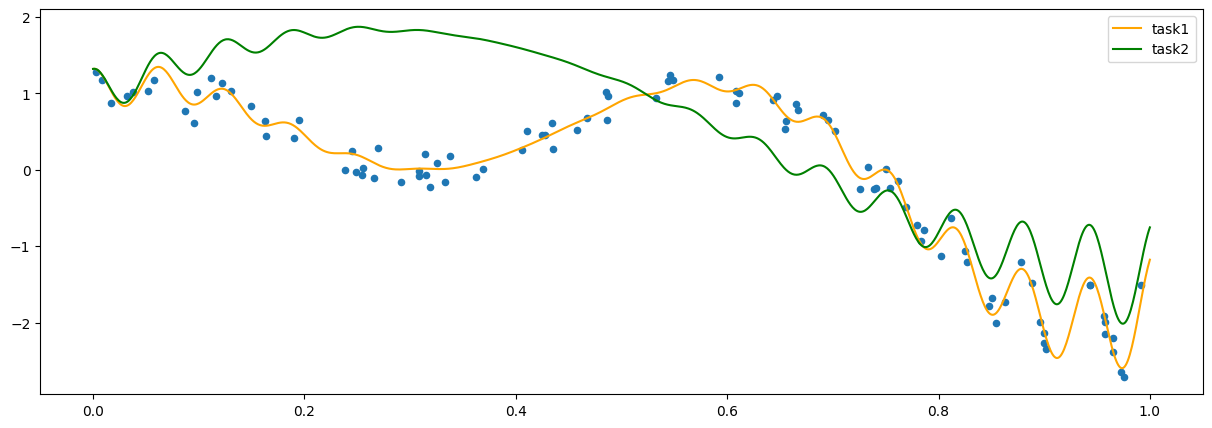

In [15]:
x = np.linspace(0,1,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

def f2(x):
    return np.sin(5. * x) + np.cos(2. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

x_data = np.random.rand(100)
y_data = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5
plt.figure(figsize = (15,5))
plt.plot(x,f1(x), color = 'orange', label = 'task1')
plt.plot(x,f2(x), color = 'green',  label = 'task2')
plt.legend()
plt.scatter(x_data,y_data, s = 20)

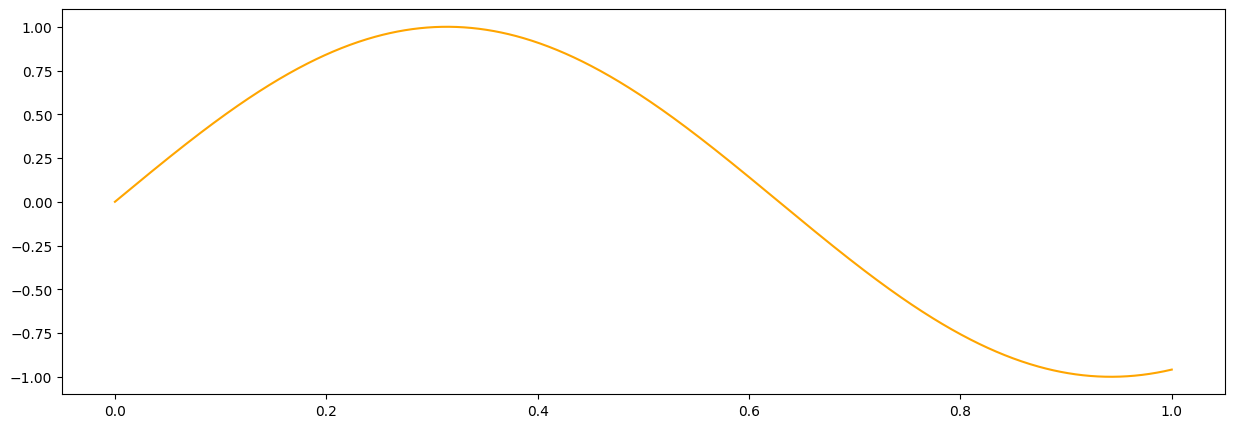

In [16]:
#stationary
def skernel(x1,x2,hps,obj):
    d = obj._get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])

def meanf(x, hps, obj):
    return np.sin(hps[2] * x)
plt.figure(figsize = (15,5))
plt.plot(x,meanf(x, np.array([1.,1.,5.0]), None), color = 'orange', label = 'task1')

In [20]:
my_gp1 = GP(1, x_data,y_data,np.ones((2)),
            variances=None, 
            compute_device='cpu', 
            gp_kernel_function=None, 
            gp_kernel_function_grad=None, 
            gp_mean_function=None, 
            gp_mean_function_grad=None,  
            normalize_y=False,
            sparse_mode=True,
            store_inv=True, 
            ram_economy=True, 
            args=None,
            )



plt.scatter(my_gp1.x_data,my_gp1.y_data, s = 20)
plt.show()
x_pred = np.linspace(0,1,1000)

my_gp1.update_gp_data(x_data, y_data)
my_gp1.train(np.array([[0.001,10.],[0.001,10.]]), method='global')
print("hps: ", my_gp1.get_hyperparameters())
#my_gp1.train(np.array([[0.001,10.],[0.001,10.]]), method='local')
#print(my_gp1.get_hyperparameters())
#my_gp1.train(np.array([[0.001,10.],[0.001,10.]]), method='mcmc', max_iter=1000)
#print(my_gp1.get_hyperparameters())
#my_gp1.train(np.array([[0.001,10.],[0.001,10.]]), method='hgdl')



#let's make a prediction
mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
new_x_pred = my_gp1.posterior_mean(x_pred.reshape(-1,1))["x"][:,0]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1))["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(new_x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(new_x_pred,f1(x_pred), label = "latent function", linewidth = 4)
plt.fill_between(new_x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(my_gp1.x_data,my_gp1.y_data, color = 'black')
plt.legend(fontsize = 20)
#plt.xticks([])
#plt.yticks([])
print("error: ", np.sqrt(np.sum(f1(x)-mean1)**2 / len(mean1)))



<bound method GP._default_noise_function of <fvgp.gp.GP object at 0x7f8b662f3d00>>


/home/marcus/Coding/fvGP/fvgp/gp.py:159: UserWarning: sparse_mode and store_inv enabled but they should not be used together. I'll set store_inv = False.
  warnings.warn("sparse_mode and store_inv enabled but they should not be used together. I'll set store_inv = False.")
/home/marcus/Coding/fvGP/fvgp/gp.py:162: UserWarning: You have chosen to activate sparse mode. Great! 
 But you have not supplied a kernel that is compactly supported. 
 I will use an anisotropic Wendland kernel for now.
  warnings.warn("You have chosen to activate sparse mode. Great! \n But you have not supplied a kernel that is compactly supported. \n I will use an anisotropic Wendland kernel for now.")


type: 'NoneType' object is not callable

In [5]:
#opt_obj = my_gp1.train_async(np.array([[0.001,10.],[0.001,10.]]))

/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  r = 1. / np.min(eig)
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  r = 1. / np.min(eig)
/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeW

2023-08-03 12:27:40,600 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-08-03 12:27:41,084 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-08-03 12:27:41,591 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-08-03 12:27:42,089 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-08-03 12:27:42,573 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-08-03 12:27:43,051 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-08-03 12:27:43,544 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-08-03 12:27:44,058 - distributed.utils_perf - WARNING - full garbage collections took

In [6]:
my_gp1.update_hyperparameters(opt_obj)
for entry in opt_obj.optima.list:
    print(entry)
    print("")

#my_gp1.entropy(my_gp1.prior_covariance)

{'x': array([5.21768583, 0.11435833]), 'f(x)': 33.59132621494294, 'classifier': 'zero curvature', 'Hessian eigvals': array([    0.       , 19518.4461935]), 'df/dx': array([ 0.00000000e+00, -7.21129946e-05]), '|df/dx|': 7.211299464415788e-05, 'radius': inf}

{'x': array([5.223178  , 0.11435834]), 'f(x)': 33.59132621494301, 'classifier': 'zero curvature', 'Hessian eigvals': array([    0.        , 19608.48043018]), 'df/dx': array([ 0.000000e+00, -2.227482e-05]), '|df/dx|': 2.2274820025813824e-05, 'radius': inf}

{'x': array([5.20830405, 0.11435834]), 'f(x)': 33.59132621494301, 'classifier': 'zero curvature', 'Hessian eigvals': array([    0.        , 19596.10972699]), 'df/dx': array([ 0.00000000e+00, -1.88861426e-05]), '|df/dx|': 1.8886142584051413e-05, 'radius': inf}

{'x': array([5.21554419, 0.11435834]), 'f(x)': 33.59132621494304, 'classifier': 'zero curvature', 'Hessian eigvals': array([    0.        , 19527.05952874]), 'df/dx': array([0.00000000e+00, 2.28118895e-05]), '|df/dx|': 2.281

2023-08-03 12:27:55,695 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


{'x': array([5.2101399 , 0.11435834]), 'f(x)': 33.59132621494604, 'classifier': 'zero curvature', 'Hessian eigvals': array([    0.        , 19716.04115192]), 'df/dx': array([ 0.        , -0.00014484]), '|df/dx|': 0.00014483624477179546, 'radius': inf}

{'x': array([5.21110929, 0.11435834]), 'f(x)': 33.59132621494604, 'classifier': 'zero curvature', 'Hessian eigvals': array([    0.        , 19582.22873986]), 'df/dx': array([0.00000000e+00, 7.84098688e-06]), '|df/dx|': 7.840986882001744e-06, 'radius': inf}

{'x': array([5.22547502, 0.11435834]), 'f(x)': 33.59132621494604, 'classifier': 'zero curvature', 'Hessian eigvals': array([    0.        , 19517.41793448]), 'df/dx': array([0.0000000e+00, 1.2172238e-05]), '|df/dx|': 1.217223802996159e-05, 'radius': inf}

{'x': array([5.2252971 , 0.11435833]), 'f(x)': 33.59132621494604, 'classifier': 'zero curvature', 'Hessian eigvals': array([    0.        , 19577.84363719]), 'df/dx': array([ 0.        , -0.00013554]), '|df/dx|': 0.000135542437305957

2023-08-03 12:27:56,319 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-08-03 12:27:56,752 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-08-03 12:27:57,188 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-08-03 12:27:57,620 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-08-03 12:27:58,047 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-08-03 12:27:58,465 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-08-03 12:27:58,913 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-08-03 12:27:59,282 - distributed.utils_perf - WARNING - full garbage collections took

error:  0.28841904790984624


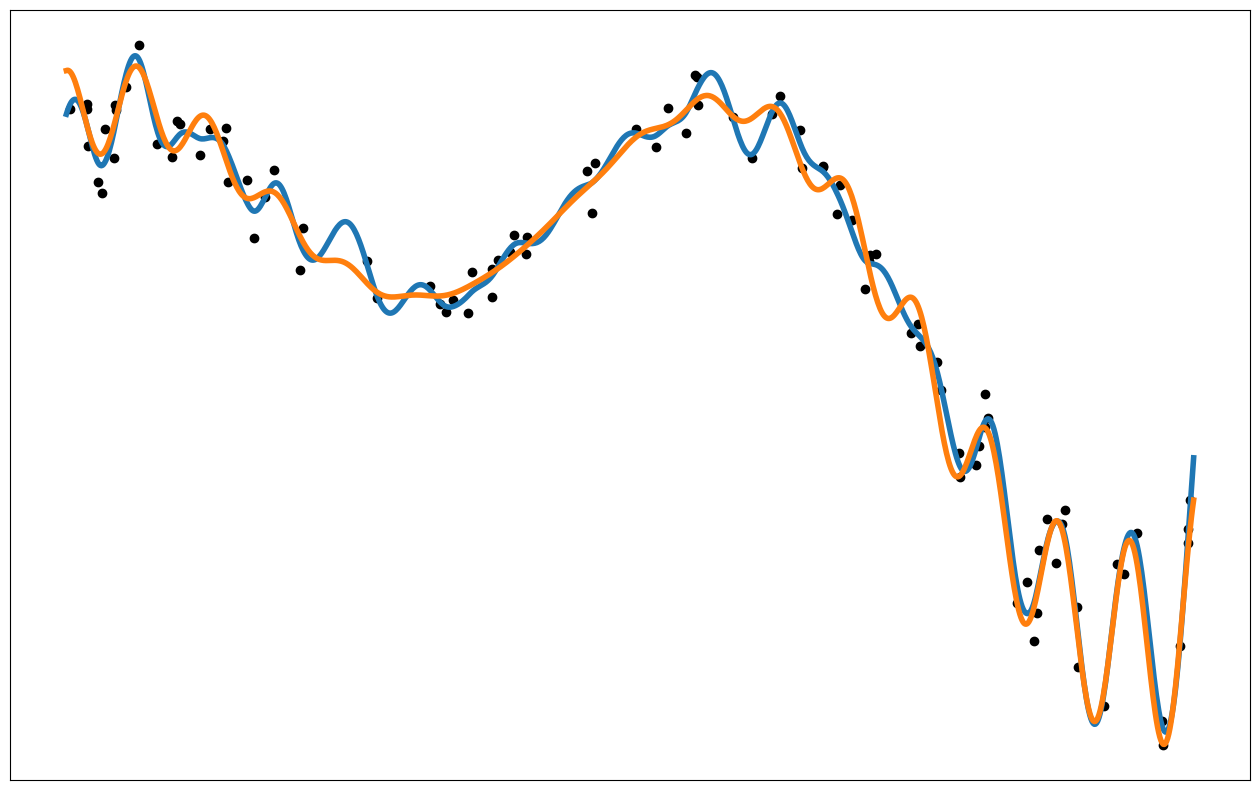

In [8]:
#let's make a prediction
mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1))["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(x_data,y_data, color = 'black')
#plt.legend(fontsize = 20)
plt.xticks([])
plt.yticks([])
print("error: ", np.sum(f1(x)-mean1)**2 / len(mean1))

In [9]:
my_gp1.stop_training(opt_obj)
my_gp1.kill_training(opt_obj)

type: No asynchronous training to be cancelled in fvGP, no training is running.

# Performance Tests

In [ ]:
import warnings

In [ ]:
a = np.random.rand(10,2)
b = np.array([[0],[1]])

In [ ]:
print(my_gp1._cartesian_prod(a,b))